<a href="https://colab.research.google.com/github/kinianlo/prlang/blob/main/archive/prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PR-like models in langauge


### Generate PR-like models with Masked LM 

In [47]:
!pip install numpy inflect torch transformers git+https://github.com/kinianlo/contextuality.git

  Cloning https://github.com/kinianlo/contextuality.git to /tmp/pip-req-build-l90s2elh
  Running command git clone -q https://github.com/kinianlo/contextuality.git /tmp/pip-req-build-l90s2elh


In [48]:
import itertools
import numpy as np
import inflect
import random
import json
import pandas as pd
from tqdm.auto import tqdm
from time import time

from contextuality.model import Model, CyclicScenario

import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import logging
logging.set_verbosity_error()

In [49]:
def get_probs(sentences_raw, options, model, tokenizer, mask_placeholder='_'):
    """
    Predict a masked word with probability scores for the provided options
    for the mask.
    
    Parameters
    ---------
    sentences_raw : str or (list of str)
    options : (list of str) or (list of (list of str))
    model : MaskedLM
    tokenizer : Tokenizer
    """
    torch.cuda.empty_cache()
    if type(sentences_raw) is str:
        sentences_raw = [sentences_raw]
    if type(options[0]) is str:
        options = [options for s in sentences_raw]
    
    partition_size = 2**8
    n_sentence = len(sentences_raw)
    if n_sentence > partition_size:
        print(f"Processing {n_sentence} sentences. Batching...")
        probs = []
        for i in tqdm(range(0, len(sentences_raw), partition_size)):
            sentences_raw_part = sentences_raw[i:i+partition_size]
            options_part = options[i:i+partition_size]
            probs += get_probs(sentences_raw_part, options_part, model,
                               tokenizer, mask_placeholder=mask_placeholder)
        return probs
        
    # Convert the option words into tokens
    options_token = [[tokenizer.tokenize(op)[0] for op in ops] for ops in options]
    options_id = [[tokenizer.vocab[op] for op in ops] for ops in options_token]
    
    # Replace mask placeholders with the mask token used by the given tokenizer
    sentences = [s.replace(mask_placeholder, tokenizer.mask_token) for s in sentences_raw]
    inputs = tokenizer(sentences, return_tensors='pt', padding=True).to(model.device)
    
    mask_indices = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)
    
    outputs = model(**inputs)
    logits = outputs.logits
    
    mask_logits = logits[mask_indices]
    
    probs = [[] for i in range(len(sentences))]
    
    for i in range(len(mask_indices[0])):
        s_idx, m_idx = mask_indices[0][i], mask_indices[1][i]
        prob = torch.softmax(mask_logits[i][options_id[s_idx]], dim=-1).detach().cpu().numpy()
        prob = dict(zip(options[s_idx], prob))
        probs[s_idx] = prob
        
    if len(probs) == 1:
        probs = probs[0]
    return probs

In [50]:
# Initialise the language model and its tokenizer
device = "cuda:0" if torch.cuda.is_available() else "cpu"
lm_name = 'bert-base-uncased'
mlm = AutoModelForMaskedLM.from_pretrained(lm_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(lm_name)

## The following handles a batch of examples
Examples should be given in a text file where each row has the format:

```outcome1 outcome2: observable1 observable2 observable3 observable4 ...```

For example,

```apple strawberry: sweet red round green big```

For each row, all ordered combinations of 3 observables will be considered in the following.

In [51]:
def process_topics_file(file_name):
    topics = []
    with open(file_name) as file:
        for row in file:
            if not row.strip():
                continue
            outcomes = [] 
            observables = []
            outcomes_str, observables_str = map(str.strip, row.split(':'))
            outcomes = list(map(str.strip, set(outcomes_str.split(','))))
            observables = list(map(str.strip, set(observables_str.split(','))))
            topics.append((outcomes, observables))
    return topics

def process_schemas_file(file_name):
    schema_options = dict()
    schemas = dict()
    with open(file_name) as file:
        data = json.load(file)
        schema_options = data['options']
        schemas = data['schemas']
    return schema_options, schemas

In [52]:
def generate_scenarios(topics, schema=None):
    scenarios = []
    for topic in topics:
        outcomes, observables = topic
        out_perm = itertools.permutations(outcomes, 2)
        obs_perm = itertools.permutations(observables, 3)
        scenarios += list(itertools.product(out_perm, obs_perm))
    return scenarios

In [53]:
def a(word):
    """Return `a` or `an` depending on the given word.
    """
    return inflect.engine().a(word)

def generate_sentences(scenario, schema):
    sentences = []
    o, x = scenario
    if schema == 'adj':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is {x[0]} and the same one is {x[1]}.")
        sentences.append(f"{intro} The _ is {x[1]} and the same one is {x[2]}.")
        sentences.append(f"{intro} The _ is {x[2]} and the other one is {x[0]}.")
    elif schema == 'verb':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is being {x[0]} and the same one is being {x[1]}.")
        sentences.append(f"{intro} The _ is being {x[1]} and the same one is being {x[2]}.")
        sentences.append(f"{intro} The _ is being {x[2]} and the other one is being {x[0]}.")
    elif schema == 'prep':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is {x[0]} and the same one is {x[1]}.")
        sentences.append(f"{intro} The _ is {x[1]} and the same one is {x[2]}.")
        sentences.append(f"{intro} The _ is {x[2]} and the other one is {x[0]}.")
    return sentences

def get_mask_options(scenario, schema):
    o, x = scenario
    return [o for i in range(3)]

# Load topics files here!


In [54]:
%cd
%rm -rf prlang
!git clone https://github.com/kinianlo/prlang.git
%cd prlang

/root
Cloning into 'prlang'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 109 (delta 54), reused 57 (delta 19), pack-reused 0
Receiving objects: 100% (109/109), 191.99 KiB | 6.86 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/root/prlang


In [55]:
topics = process_topics_file('data/prep.txt')
schema = 'prep'

print(f'Topics for schema `{schema}`:')
for t in topics:
    print(t)

Topics for schema `prep`:
(['apple', 'strawberry'], ['in a dish', 'in the fridge', 'on the table'])
(['girl', 'boy'], ['across the street', 'on a bus', 'in the city', 'near the shop', 'from the town', 'at the school'])


In [56]:
df = pd.DataFrame(columns=['nouns', 'modifiers', 'models', 'contextual_models'])

sfs_list = []
sheaf_models_list = []

for topic in topics:
    row = dict()
    scenarios = generate_scenarios([topic], schema)
    print(f"Curent topic: {topic}")
    row['nouns'], row['modifiers'] = topic

    n_scenario = len(scenarios)
    row['models'] = n_scenario
    print(f"Number of scenarios: {n_scenario}")
    
    sentences = [generate_sentences(scen, schema) for scen in scenarios]
    sentences_flat = list(itertools.chain.from_iterable(sentences))

    mask_options = [get_mask_options(scen, schema) for scen in scenarios]
    mask_options_flat = list(itertools.chain.from_iterable(mask_options))

    probs_flat = get_probs(sentences_flat, mask_options_flat, mlm, tokenizer)
    probs = [probs_flat[3*i:3*i+3] for i in range(n_scenario)]

    sheaf_models = []
    cbd_models = []
    sfs = []
    cbds = []
    for i in range(n_scenario):
        outcomes, observables = scenarios[i]
        tri_scenario = CyclicScenario(observables, 2)
        o0, o1 = outcomes
        x0, x1, x2 = observables
        
        table = []
        table.append([probs[i][0][o0], 0, 0, probs[i][0][o1]])
        table.append([probs[i][1][o0], 0, 0, probs[i][1][o1]])
        table.append([0, probs[i][2][o0], probs[i][2][o1], 0])
        
        model = Model(tri_scenario, table)
        sfs.append(model.signalling_fraction())
        cbds.append(model.CbD_measure())
        if sfs[-1] < 1/6:
            sheaf_models.append(model)
            for s in sentences[i]:
                print(s)
            print(model)
            print(f"Signalling fraction: {model.signalling_fraction()}")
            print(f"\\model{{{o0}}}{{{o1}}}{{{x0}}}{{{x1}}}{{{x2}}}{{{probs[i][0][o0]}}}{{{probs[i][1][o0]}}}{{{probs[i][2][o0]}}}")
            print('='*60)
        
        if cbds[-1] > 0:
            cbd_models.append(model)
    sheaf_models_list += sheaf_models
    sfs_list += sfs
    row['contextual_models'] = len(sheaf_models)
    df = df.append(row, ignore_index=True)

Curent topic: (['apple', 'strawberry'], ['in a dish', 'in the fridge', 'on the table'])
Number of scenarios: 12
There is an apple and a strawberry. The _ is on the table and the same one is in the fridge.
There is an apple and a strawberry. The _ is in the fridge and the same one is in a dish.
There is an apple and a strawberry. The _ is in a dish and the other one is on the table.
                              (0, 0) (0, 1) (1, 0) (1, 1)
(on the table, in the fridge) 0.5591 0.0000 0.0000 0.4409
(in the fridge, in a dish) 0.5640 0.0000 0.0000 0.4360
(in a dish, on the table) 0.0000 0.4778 0.5222 0.0000

Signalling fraction: 0.12791317666402535
\model{apple}{strawberry}{on the table}{in the fridge}{in a dish}{0.5590721368789673}{0.563956618309021}{0.4777790307998657}
Curent topic: (['girl', 'boy'], ['across the street', 'on a bus', 'in the city', 'near the shop', 'from the town', 'at the school'])
Number of scenarios: 240
Processing 720 sentences. Batching...


  0%|          | 0/3 [00:00<?, ?it/s]

There is a girl and a boy. The _ is across the street and the same one is on a bus.
There is a girl and a boy. The _ is on a bus and the same one is at the school.
There is a girl and a boy. The _ is at the school and the other one is across the street.
                                   (0, 0) (0, 1) (1, 0) (1, 1)
(across the street, on a bus) 0.5725 0.0000 0.0000 0.4275
(on a bus, at the school) 0.5274 0.0000 0.0000 0.4726
(at the school, across the street) 0.0000 0.4996 0.5004 0.0000

Signalling fraction: 0.14496433650797913
\model{girl}{boy}{across the street}{on a bus}{at the school}{0.5724821090698242}{0.5273512601852417}{0.49956968426704407}


In [57]:
df

,nouns,modifiers,models,contextual_models
0,"[apple, strawberry]","[in a dish, in the fridge, on the table]",12,1
1,"[girl, boy]","[across the street, on a bus, in the city, nea...",240,1


total number of scenarios: 252.
total number sheaf-contextual scenarios: 2(0.79%).


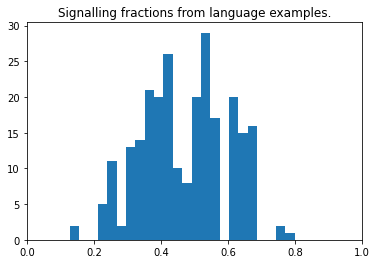

\histogram{(0.0000, 0) (0.0417, 0) (0.0833, 0) (0.1250, 2) }{(0.1667, 0) (0.2083, 5) (0.2500, 13) (0.2917, 19) (0.3333, 15) (0.3750, 36) (0.4167, 34) (0.4583, 12) (0.5000, 42) (0.5417, 20) (0.5833, 20) (0.6250, 31) (0.6667, 0) (0.7083, 0) (0.7500, 2) (0.7917, 1) (0.8333, 0) (0.8750, 0) (0.9167, 0) (0.9583, 0) }


In [58]:
import matplotlib.pyplot as plt
print(f"total number of scenarios: {len(sfs_list)}.")
print(f"total number sheaf-contextual scenarios: {len(sheaf_models_list)}({len(sheaf_models_list)/len(sfs_list)*100:.2f}%).")
plt.hist(sfs_list, bins=24)

plt.xlim((0,1))
plt.title("Signalling fractions from language examples.")
plt.show()

freq, edge = np.histogram(sfs_list, range=(0, 1), bins=24)
out1 = ''
out2 = ''
for f, e in zip(freq, edge[:-1]):
    if e < 1/6-1e-5:
        out1 += f"({e:.4f}, {f}) "
    else:
        out2 += f"({e:.4f}, {f}) "
print(f'\\histogram{{{out1}}}{{{out2}}}')

In [59]:
# print(f"total number of scenarios: {len(cbds)}.")
# plt.hist(cbds, bins=50)

# plt.title("CbD from language examples.")
# plt.show()

In [60]:
# print(cbd_models[0])
# print(cbd_models[0].CbD_measure())

In [61]:
# from contextuality.model import random_pr_like_model
# random_sfs = []
# for i in range(n_scenario):
#     model = random_pr_like_model(3)
#     random_sfs.append(model.signalling_fraction())

# plt.hist(random_sfs, bins=50)
# plt.xlim((0,1))
# plt.title("Signalling fractions from random models")
# plt.show()